## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This is a study project for practice of A/B testing for students of Data Analyst nanodegree by Udacity. Various statistics tests are performed by student in order to decide if company should implement new design of website or keep the old website as it is.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]


294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df[df['converted']==1].count()[0])/df['user_id'].nunique()


0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:

df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))==True].count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))==True].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
(df2['user_id'].value_counts()).head()


773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(2893, axis=0, inplace=True)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
cr_old = df2.query("group=='control'& converted==1").count()[0]/df2.query("group=='control'").shape[0]
cr_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
cr_new = df2.query("group=='treatment'& converted==1").count()[0]/df2.query("group=='treatment'").shape[0]
cr_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2.query("landing_page=='new_page'").count()[0])/df2.shape[0]


0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [18]:
obs_diff = cr_new - cr_old
obs_diff

-0.0015782389853555567

## Evidence to decide in favour of old vs. page?

- Conversion rate for all group is 11,96 %, while **conversion rate for control group is slightly higher (12,04 %) than for treatment group (11,88 %)**. Therefore observed difference is only -0,016 %. To determine if the result is statistically significant, we would need to find p-value.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

## Null and alternative hypothesis:

$$ H_0 : P_{old} - P_{new} \geq 0$$

$$ H_1 : P_{old} - P_{new} < 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
con = df2.query("group=='control'")
treat = df2.query("group=='treatment'")

In [20]:
cr_new = df2.converted.mean()
cr_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
cr_old = df2.converted.mean()
cr_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = treat.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = con.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, cr_new, n_new)
new_page_converted

array([0, 0, 1, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, cr_old, n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00063101716375625616

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
for i in range(10000):
    old_page_converted = np.random.binomial(1, cr_old, n_old)
    new_page_converted = np.random.binomial(1, cr_new, n_new)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

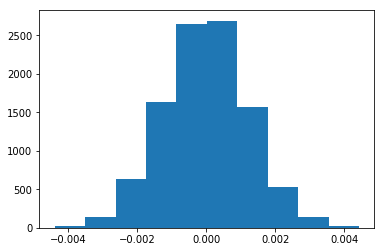

In [28]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

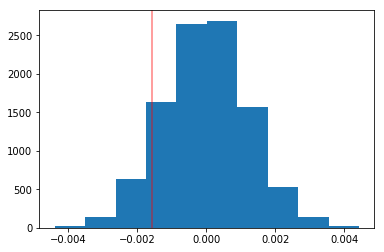

In [29]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='r', alpha=0.5);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# p - value 
(p_diffs > obs_diff).mean()

0.90139999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- We counted **p-value** to determine statistical significance of our test. Result of **p-value (90,61 %) is much bigger than $\alpha$ (0,05 %)**. Therefore we **cannot reject null hypothesis** meaning that **conversion rate for old page is higher or equal to conversion rate of new page**.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query("group=='control'& converted==1").count()[0]
convert_new = df2.query("group=='treatment'& converted==1").count()[0]

n_old = df2.query("landing_page=='old_page'").count()[0]
n_new = df2.query("landing_page=='new_page'").count()[0]
n_old, n_new, convert_old, convert_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(145274, 145310, 17489, 17264)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
# We have two sample test where alternative hypothesis is p1 < p2, therefore alternative is smaller
sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='smaller')

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

## **Conclusion:**

- Ztest has returned **zstat: 1,31 and p-value 90,51 %**. P-value is again much greater than $\alpha $, therefore we can not reject null hypothesis and have to state that **old page has higher or equal conversion rate then new page**.
-  Statistical significance is determined by zstat value. For upper tailed Z test, which is our case, we can reject null hypothesis for $\alpha $ = 0,05 % when the zstat is greater than 1,645 based on this table [Boston University](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html). But our **zstat 1,31 < 1,645**, so we need to **keep null hypothesis**. That is the same result as in parts **j.** and **k.**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**For cathegorical variable with binary outcome we use logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
df2['intercept']=1
df2[['ab_page', 'control']]= pd.get_dummies(df['landing_page'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [35]:
df3 = df2.copy()
df3.drop(['timestamp', 'control', 'group', 'landing_page'], axis=1, inplace=True)
df3.head()

,user_id,converted,intercept,ab_page
0,851104,0,1,0
1,804228,0,1,0
2,661590,0,1,1
3,853541,0,1,1
4,864975,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-21 15:36 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [38]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [39]:
1/(np.exp(results.params))

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**
- P-value associated with ab_page is 0,19, showing again this is not **statistically significant result** because p-value > $ \alpha $.
- Results in part II and part III differ because in part II we did one tailed test and in part III we did two tailed test.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
- We have option to **add timestamp variable**, because people do react differently when they browse on internet during working hours, afternoon after work or in the evening, or weekdays vs. weekends. We could divide day into few cathegories (hour intervals from 06:00 to 09:00, from 09:01 to 12:00, etc.) and days to 7 cathegories going from Monday to Sunday. 
    - **advantage of time related variable**: It can help us interpret why comparison of conversion of old and new pages can be in favour of one or the other.
    - **disadvantage of time related variable**: when adding more variables we increase danger of covariability between variables, even though here it probably won't be the case.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
new_table = df3.set_index('user_id').join(countries.set_index('user_id'))

In [42]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 851104 to 715931
Data columns (total 4 columns):
converted    290584 non-null int64
intercept    290584 non-null int64
ab_page      290584 non-null uint8
country      290584 non-null object
dtypes: int64(2), object(1), uint8(1)
memory usage: 19.1+ MB


In [43]:
new_table['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [44]:
new_table[['CA','UK','US']] = pd.get_dummies(new_table['country'])
new_table.head(10)

,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,
851104,0,1,0,US,0,0,1
804228,0,1,0,US,0,0,1
661590,0,1,1,US,0,0,1
853541,0,1,1,US,0,0,1
864975,1,1,0,US,0,0,1
936923,0,1,0,US,0,0,1
679687,1,1,1,CA,1,0,0
719014,0,1,0,US,0,0,1
817355,1,1,1,UK,0,1,0


In [45]:
new_table['intercept']=1
new_table.drop(['country','CA'], axis=1, inplace=True)
new_table.head(10)

,converted,intercept,ab_page,UK,US
user_id,,,,,
851104,0,1,0,0,1
804228,0,1,0,0,1
661590,0,1,1,0,1
853541,0,1,1,0,1
864975,1,1,0,0,1
936923,0,1,0,0,1
679687,1,1,1,0,0
719014,0,1,0,0,1
817355,1,1,1,1,0


In [46]:
logit_mod = sm.Logit(new_table['converted'], new_table[['intercept', 'ab_page', 'UK', 'US']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-21 15:36 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

In [47]:
# exponentionation of coeficients beacuse it is logistic regression
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [48]:
# change of coeficients for ab_page for easier interpretation
1/0.985168

1.0150553002127556

## Conclusions:

- For each unit decrease of new page shown to viewers, conversion is 1.5 % more likely holding all variables constant.
- Viewer from UK is 5,2 % more likely to convert than viewer from Canada.
- Viewer from US is 4,2 % more likely to convert than viewer from Canada.
- All **p-values are greater than 0.05**, therefore we have to **keep null hypothesis** that old page has bigger or equal conversion rate as new page, so **introducing new page does not make sense for a company**.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
int_table = new_table.copy()
int_table['UK_ab_page'] = int_table['ab_page']* int_table['UK']
int_table['US_ab_page'] = int_table['ab_page']* int_table['US']
int_table.head()

,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,
851104,0,1,0,0,1,0,0
804228,0,1,0,0,1,0,0
661590,0,1,1,0,1,0,1
853541,0,1,1,0,1,0,1
864975,1,1,0,0,1,0,0


In [50]:
int_table['intercept']=1
logit_mod = sm.Logit(int_table['converted'], int_table[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-21 15:36 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [51]:
np.exp(results.params)

intercept     0.134794
ab_page       0.934776
UK            1.011854
US            1.017682
UK_ab_page    1.081428
US_ab_page    1.048001
dtype: float64

## Summary of interactions conversion * country
- We can see all variables have higher p-value than $ \alpha$ on 95% confidence interval, therefore adding interaction between country and conversion did not shed any more light into our analysis. It speaks in favour of **keeping null hypothesis**.

# Conclusion of all results

- We can **not recommend to apply new page** because both methods **(hypothesis testing and logistic regression) did not provide us any significant evidence to reject null hypothesis**, therefore we must conclude that **old page has better or same conversion rate is new page**.

### Sources used:
- Interpretation of Z score: http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html
- Problem with command result.summary() not working solved based on this Udacity tread: https://knowledge.udacity.com/questions/83573
- I was stucked on last question with interaction model, so this forum answer solved it: https://knowledge.udacity.com/questions/38871



<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0